- We obtained 2011 and 2020 population data from the US Census Bureau. The data was downloaded from the following repository: [https://data.census.gov/table?q=ohio+counties+population](https://data.census.gov/table?q=ohio+counties+population)
- Data preprocessing steps and all `ppd.` functions used in this code was abstracted into its own module: `src/preprocess_data.py`. The code has been attached to the end of this notebook for reference.
- An interactive Plotly/Dash app was create to visualize the data which can highlight adjacent counties on mouse hover, display the county_id in multiple formats and highlight the obtained optimal solutions. The script is in the `src/visualization.py` file
- All code used in this project is also available on the GitHub repository: [https://github.com/adbX/ise-533-hw1](https://github.com/adbX/ise-533-hw1)

In [1]:
import pyomo.environ as pyo
import pandas as pd
from pathlib import Path
import preprocess_data as ppd
from itertools import zip_longest
from IPython.display import display, Image, Latex

# from Camm18 paper to verify obtained results later
known_x_sols = [
    [8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87],
    [4, 8, 14, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87],
    [8, 14, 17, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87],
]

## 1. Solve Camm18's network location problem for 2011 data {-}

### Data import {-}

In [2]:
data_path = Path("../data/")
output_path = Path("../output/")
df, adjacent_matrix = ppd.get_df_adj(data_path, 2021)

### Constraint equation definitions {-}

In [3]:
def param_adjacent(m, i, j):
    return int(j in adjacent_matrix[i])

def param_pop_2011(m, i):
    return df["population_2010"][i - 1]

def param_pop_2020(m, i):
    return df["population_2020"][i - 1]

def con_a(m, i):
    return sum((m.a[i, j] * m.x[j]) for j in m.J) >= m.y[i]

def con_x(m):
    return sum(m.x[j] for j in m.J) <= m.k

def obj_sum(m):
    return pyo.summation(m.p, m.y)

### Model setup {-}

In [4]:
def instantiate_model(name, year=2011, k=15):
    name = pyo.AbstractModel()
    
    # value of n (number of counties)
    name.n = 88

    # limit on number of pirincipal places of buisnesses opened (init to 5)
    name.k = k

    # range of i and j (iterating over counties)
    name.I = pyo.RangeSet(1, name.n)
    name.J = pyo.RangeSet(1, name.n)

    if year==2011:
        name.p = pyo.Param(name.I, initialize=param_pop_2011)
    elif year==2020:
        name.p = pyo.Param(name.I, initialize=param_pop_2020)  # population of county i

    name.a = pyo.Param(
        name.I, name.J, domain=pyo.Binary, initialize=param_adjacent
    )  # 1 if county i and j are adjacent

    name.x = pyo.Var(
        name.J, domain=pyo.Binary
    )  # 1 if principal place of business is opened in county j
    name.y = pyo.Var(name.I, domain=pyo.Binary)  # 1 if county i is covered

    name.obj = pyo.Objective(rule=obj_sum, sense=pyo.maximize)

    name.a_constraint = pyo.Constraint(name.I, rule=con_a)
    
    name.x_constraint = pyo.Constraint(rule=con_x)
    
    return name

### First solution {-}

In [5]:
model = instantiate_model("model", 2011)
# opt = pyo.SolverFactory("ipopt", executable="/home/adb/anaconda3/bin/ipopt")
opt = pyo.SolverFactory("glpk", executable="/home/adb/anaconda3/bin/glpsol")
# opt = pyo.SolverFactory("glpk", executable="/usr/local/Caskroom/miniconda/base/bin/glpsol")

In [6]:
instance1 = model.create_instance()
results1 = opt.solve(instance1)

In [7]:
def get_solutions(instance):
    sol_dict = instance.x.get_values()
    sol = [k for k, v in sol_dict.items() if v == 1]
    return sol

def get_solution_set_inverse(solution):
    return set([i for i in range(1, model.n + 1)]) - set(solution)

In [8]:
sol1 = get_solutions(instance1)
sol1_compare = sol1
inverse_sol1 = get_solution_set_inverse(sol1)
sol1_camm = ppd.county_ids_to_camm_ids(df, sol1)
pd.Series(sol1).to_csv(
    output_path / "solution_main_model_sol1.csv", index=False, header=["county_id"]
)

In [9]:
print(f"Obtained Solution 1 with Camm18 indexing method: \n{sol1_camm}")
print(f"Solution 1 from Camm18 paper: \n{known_x_sols[0]}")
print(f"Obtained counties: \n{df[df['camm_id'].isin(sol1_camm)]['county'].values}")

Obtained Solution 1 with Camm18 indexing method: 
[8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87]
Solution 1 from Camm18 paper: 
[8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87]
Obtained counties: 
['Ashland County' 'Athens County' 'Belmont County' 'Brown County'
 'Butler County' 'Fulton County' 'Geauga County' 'Jackson County'
 'Licking County' 'Madison County' 'Marion County' 'Putnam County'
 'Sandusky County' 'Shelby County' 'Stark County']


Solution 1 visualization: 

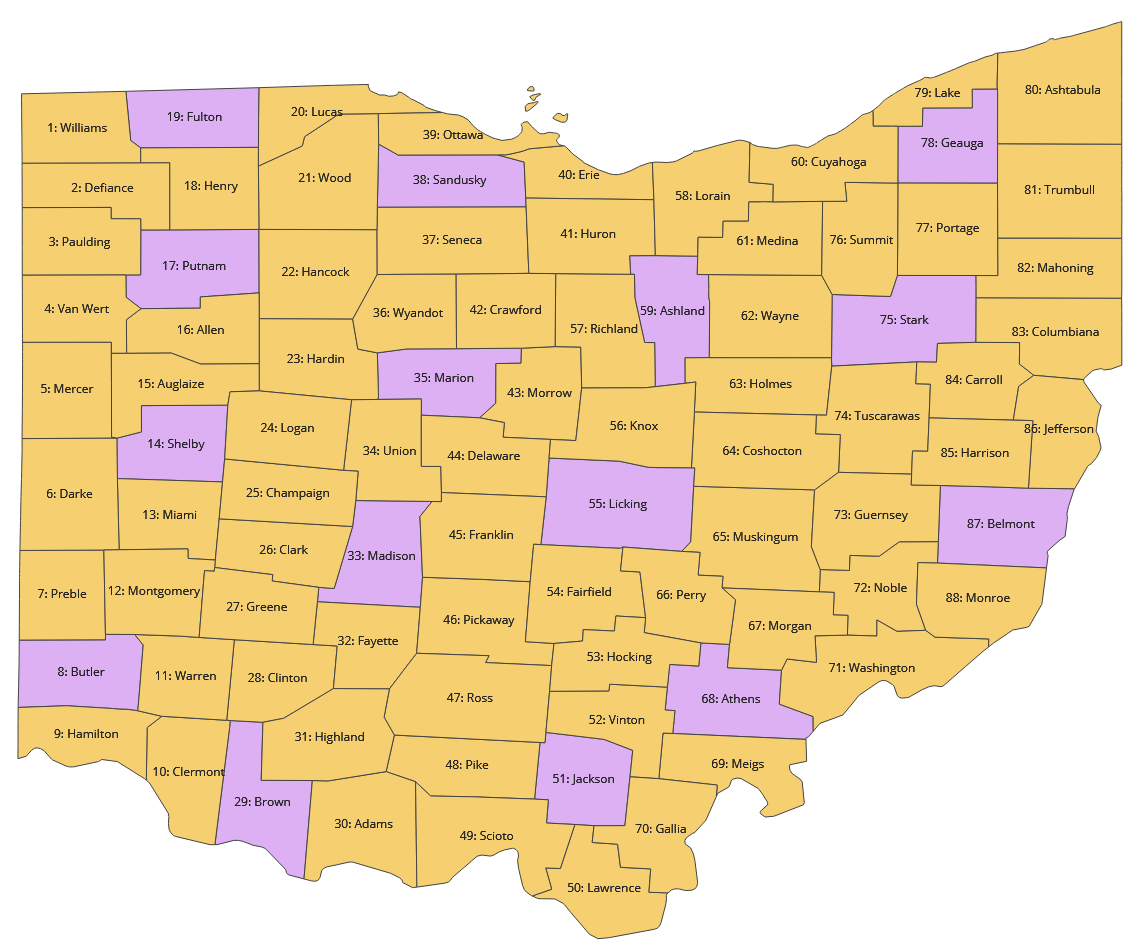

In [10]:
display(Image(filename="../output/image_solution_1.png", width=600))

### Re-solve for 2nd solution {-}

In [11]:
def con_x_sol2(m):
    return sum(m.x[i] for i in sol1) - sum(m.x[j] for j in inverse_sol1) <= len(sol1) - 1


model.sol2_constraint = pyo.Constraint(rule=con_x_sol2)

instance2 = model.create_instance()
results2 = opt.solve(instance2)

In [12]:
sol2 = get_solutions(instance2)
inverse_sol2 = get_solution_set_inverse(sol2)
sol2_camm = ppd.county_ids_to_camm_ids(df, sol2)
pd.Series(sol2).to_csv(
    output_path / "solution_main_model_sol2.csv", index=False, header=["county_id"]
)

In [13]:
print(f"Obtained Solution 2: \n{sol2_camm}")
print(f"Solution 2 from Camm18 paper: \n{known_x_sols[2]}")
print(f"Obtained counties: \n{df[df['camm_id'].isin(sol2_camm)]['county'].values}")

Obtained Solution 2: 
[8, 14, 17, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87]
Solution 2 from Camm18 paper: 
[8, 14, 17, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87]
Obtained counties: 
['Ashland County' 'Athens County' 'Belmont County' 'Brown County'
 'Butler County' 'Geauga County' 'Henry County' 'Jackson County'
 'Licking County' 'Madison County' 'Marion County' 'Putnam County'
 'Sandusky County' 'Shelby County' 'Stark County']


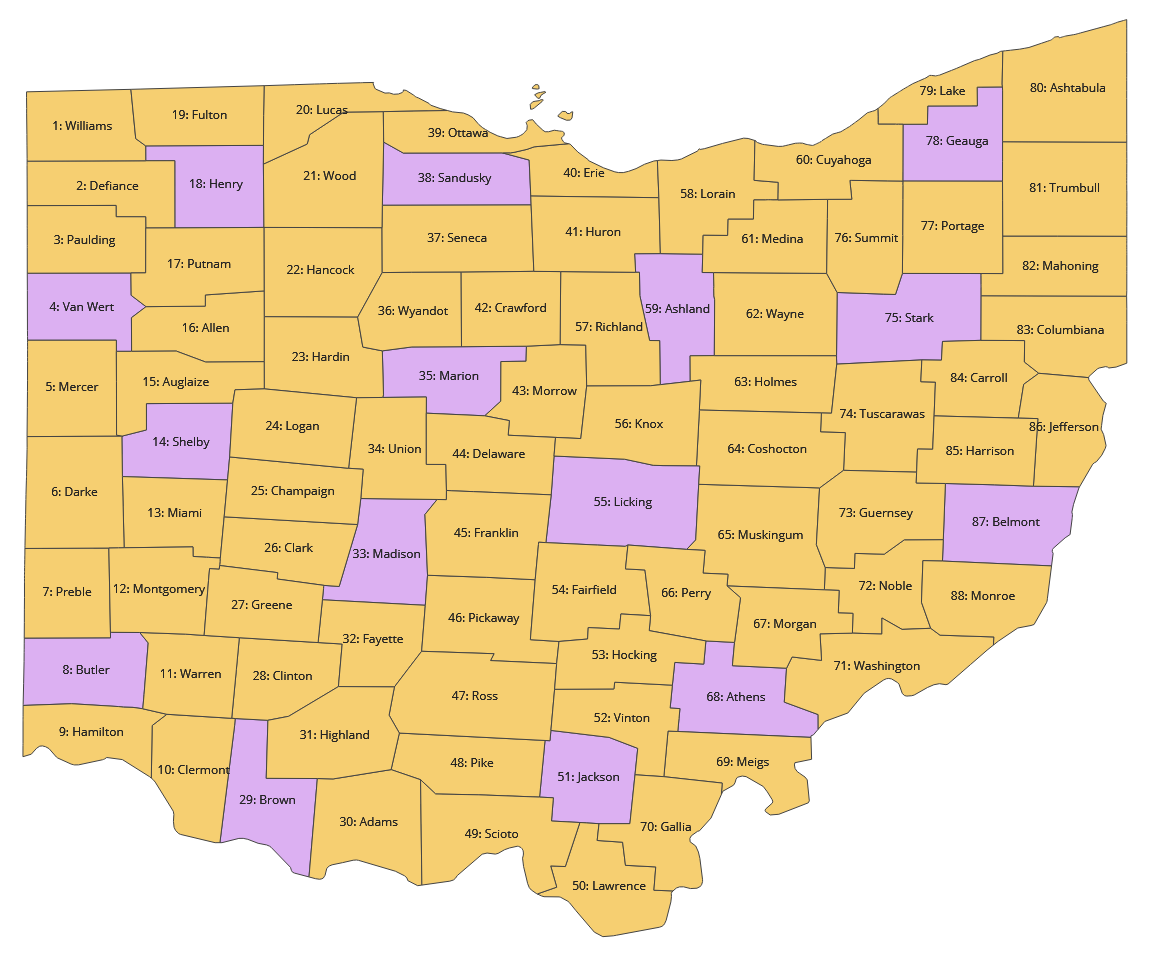

In [14]:
display(Image(filename="../output/image_solution_2.png", width=600))

### Re-solve for 3rd solution {-}

In [15]:
def con_x_sol3(m):
    return sum(m.x[i] for i in sol2) - sum(m.x[j] for j in inverse_sol2) <= len(sol2) - 1


model.sol3_constraint = pyo.Constraint(rule=con_x_sol3)

instance3 = model.create_instance()
results3 = opt.solve(instance3)

In [16]:
sol3 = get_solutions(instance3)
inverse_sol3 = get_solution_set_inverse(sol3)
sol3_camm = ppd.county_ids_to_camm_ids(df, sol3)
pd.Series(sol3).to_csv(
    output_path / "solution_main_model_sol3.csv", index=False, header=["county_id"]
)

In [17]:
print(f"Obtained Solution 3\n{sol3_camm}")
print(f"Solution 3 from Camm18 paper: \n{known_x_sols[1]}")
print(f"Obtained counties: \n{df[df['camm_id'].isin(sol3_camm)]['county'].values}")

Obtained Solution 3
[4, 8, 14, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87]
Solution 3 from Camm18 paper: 
[4, 8, 14, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87]
Obtained counties: 
['Ashland County' 'Athens County' 'Belmont County' 'Brown County'
 'Butler County' 'Geauga County' 'Henry County' 'Jackson County'
 'Licking County' 'Madison County' 'Marion County' 'Sandusky County'
 'Shelby County' 'Stark County' 'Van Wert County']


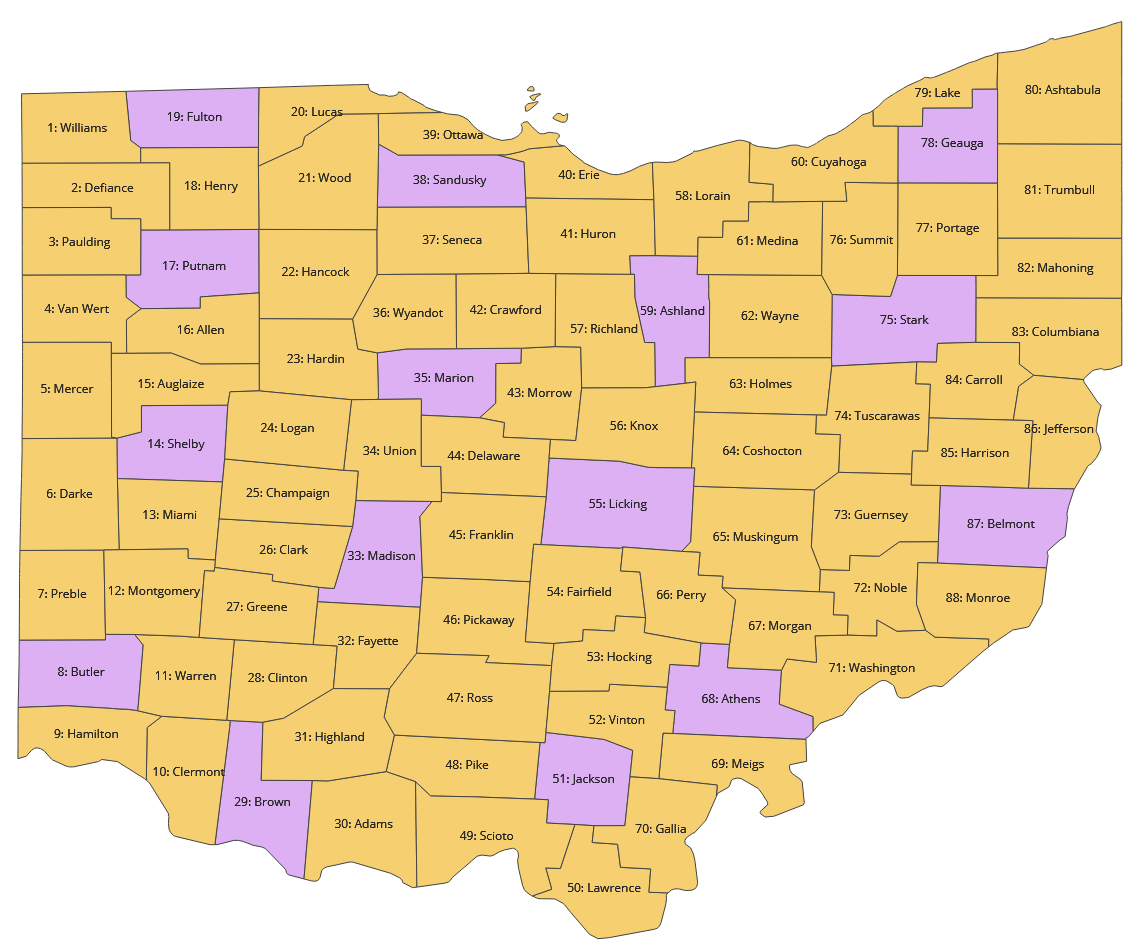

In [18]:
display(Image(filename="../output/image_solution_1.png", width=600))

### Verify obtained solutions with ones from the Camm18 paper {-}

In [19]:
print(f"Solution 1 \nResult:{sol1_camm} \nCamm18:{known_x_sols[0]} \n ----")
print(f"Solution 2 \nResult:{sol2_camm} \nCamm18:{known_x_sols[2]} \n ----")
print(f"Solution 3 \nResult:{sol3_camm} \nCamm18:{known_x_sols[1]} \n ----")

Solution 1 
Result:[8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
Camm18:[8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
 ----
Solution 2 
Result:[8, 14, 17, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
Camm18:[8, 14, 17, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
 ----
Solution 3 
Result:[4, 8, 14, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
Camm18:[4, 8, 14, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
 ----


## 2. Solve the same problem for 2020 data {-}

In [20]:
model_2020 = instantiate_model("model2020", 2020)

instance1 = model_2020.create_instance()
results1 = opt.solve(instance1)

sol1 = get_solutions(instance1)
inverse_sol1 = get_solution_set_inverse(sol1)
sol1_camm = ppd.county_ids_to_camm_ids(df, sol1)

model_2020.sol2_constraint = pyo.Constraint(rule=con_x_sol2)

instance2 = model_2020.create_instance()
results2 = opt.solve(instance2)

sol2 = get_solutions(instance2)
inverse_sol2 = get_solution_set_inverse(sol2)
sol2_camm = ppd.county_ids_to_camm_ids(df, sol2)

model_2020.sol3_constraint = pyo.Constraint(rule=con_x_sol3)

instance3 = model_2020.create_instance()
results3 = opt.solve(instance3)

sol3 = get_solutions(instance3)
inverse_sol3 = get_solution_set_inverse(sol3)
sol3_camm = ppd.county_ids_to_camm_ids(df, sol3)

print(f"Solution 1 \nResult:{sol1_camm} \nCamm18:{known_x_sols[1]} \n ----")
print(f"Solution 2 \nResult:{sol2_camm} \nCamm18:{known_x_sols[0]} \n ----")
print(f"Solution 3 \nResult:{sol3_camm} \nCamm18:{known_x_sols[2]} \n ----")

Solution 1 
Result:[4, 8, 14, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
Camm18:[4, 8, 14, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
 ----
Solution 2 
Result:[8, 14, 17, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
Camm18:[8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
 ----
Solution 3 
Result:[8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
Camm18:[8, 14, 17, 18, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87] 
 ----


We observe that the $x_i$ solution sets are indentical for both the 2020 and 2011 population datasets.

## 3. Verify Camm18's 3 year-implementation method {-}

We use the first solution set from the 2011 data to verify the 3 year-implementation method from the paper. We will instantiate a new model using our previously created template but with `k=5` which will constrain the number of solutions $x_i$ to 5 for each run.

In [21]:
solution_set_initial = sol1_compare
solution_set_initial_camm = ppd.county_ids_to_camm_ids(df, solution_set_initial)

## Year 1
model1 = instantiate_model("model_verify", 2011, k=5)
instance1 = model1.create_instance()

# We fix the all solutions not in initial solution set to 0
for i in get_solution_set_inverse(solution_set_initial):
    instance1.x[i].fix(0)

results1 = opt.solve(instance1)
sol1 = get_solutions(instance1)
inverse_sol1 = get_solution_set_inverse(sol1)
sol1_camm = ppd.county_ids_to_camm_ids(df, sol1)

## Year 2
model2 = instantiate_model("model_verify", 2011, k=10)
instance2 = model2.create_instance()

## We fix x_i to 1 for the solution set from year 1
for i in get_solution_set_inverse(solution_set_initial):
    instance1.x[i].fix(0)
for i in sol1:
    instance2.x[i].fix(1)

results2 = opt.solve(instance2)
sol2 = get_solutions(instance2)
inverse_sol2 = get_solution_set_inverse(sol2)
sol2_camm = ppd.county_ids_to_camm_ids(df, sol2)

## Year 3
model3 = instantiate_model("model_verify", 2011, k=15)
instance3 = model3.create_instance()

## We fix x_i to 1 for the solution set from year 2
for i in get_solution_set_inverse(solution_set_initial):
    instance1.x[i].fix(0)
for i in sol1:
    instance2.x[i].fix(1)
for i in sol2:
    instance3.x[i].fix(1)

results3 = opt.solve(instance3)
sol3 = get_solutions(instance3)
inverse_sol3 = get_solution_set_inverse(sol3)
sol3_camm = ppd.county_ids_to_camm_ids(df, sol3)

extraneous = set(solution_set_initial_camm) - set(sol3_camm)
missing = set(sol3_camm) - set(solution_set_initial_camm)

Initial solution set:

In [22]:
print(solution_set_initial_camm)
print(df[df['camm_id'].isin(solution_set_initial_camm)]['county'].values)

[8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87]
['Ashland County' 'Athens County' 'Belmont County' 'Brown County'
 'Butler County' 'Fulton County' 'Geauga County' 'Jackson County'
 'Licking County' 'Madison County' 'Marion County' 'Putnam County'
 'Sandusky County' 'Shelby County' 'Stark County']


Our calculated 3 year glide path:

In [23]:
print(f"Year 1: {sol1_camm}")
print(f"Year 2: {list(set(sol2_camm) - set(sol1_camm))}")
print(f"Year 3: {list(set(sol3_camm) - set(sol2_camm))}")

Year 1: [8, 55, 59, 75, 78]
Year 2: [15, 51, 21, 25, 28]
Year 3: [68, 41, 42, 18, 87]


Our calculated 3-year implementation:

In [24]:
print(sol3_camm)
print(df[df['camm_id'].isin(sol3_camm)]['county'].values)


[8, 15, 18, 21, 25, 28, 41, 42, 51, 55, 59, 68, 75, 78, 87]
['Ashland County' 'Athens County' 'Auglaize County' 'Belmont County'
 'Butler County' 'Champaign County' 'Clinton County' 'Crawford County'
 'Geauga County' 'Henry County' 'Huron County' 'Jackson County'
 'Licking County' 'Stark County' 'Wood County']


Our calculated first year solution is completely contained in the initial solution set from part 2. However the solutions for the second and third years diverge as follows:

In [25]:
print(f"Counties missing from our year 3 solution that are in the initial solution set: \n{missing} \n{df[df['camm_id'].isin(missing)]['county'].values}\n")
print(f"Counties included in our year 3 solution that are not the initial solution set: \n{extraneous} \n{df[df['camm_id'].isin(extraneous)]['county'].values}\n")

Counties missing from our year 3 solution that are in the initial solution set: 
{41, 42, 15, 18, 21, 25, 28} 
['Auglaize County' 'Champaign County' 'Clinton County' 'Crawford County'
 'Henry County' 'Huron County' 'Wood County']

Counties included in our year 3 solution that are not the initial solution set: 
{33, 35, 38, 14, 17, 19, 29} 
['Brown County' 'Fulton County' 'Madison County' 'Marion County'
 'Putnam County' 'Sandusky County' 'Shelby County']



## 4. Mathematical setup to ensure glide-path given 2020 data in 2010 {-}

Since we are given 2020 population data, we will solve the following MCP model with the given data:

$$Maximize \qquad \sum_{i=1}^{88}pop_iy_i$$
$$\text{subject to}$$
$$\sum_{i=1}^{88}a_{ij}x_j \geq y_i \quad i = 1,2,...,88$$
$$\sum_{i=1}^{88}x_j \leq k$$
$$x_j, y_j \in {0,1} \qquad i,j = 1,2,...,88$$

Where:
$$ x_i = 1 \text{  if a principal place of business is located in county }j\text{ and 0 otherwise}$$
$$ y_i = 1 \text{  if county }i\text{ is covered by by a principal place of business and 0 otherwise}$$
$$ a_{ij} = 1 \text{  if county }i\text{ and county }j\text{ share a border and 0 otherwise}$$
$$ pop_{i} = 1 \text{  population of county }i\text{ in the year 2020}$$

We then obtain the folowing optimal solution for this example: 
$$\mathrm{O} = \{8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87\}$$

After we get the optimal solution, we can use it to generate a glide path:
- We want this solution to be the end state over 2011-2020 implementation period
- First, we set all variables not in the solution to zero
 that is, $x_j = 0$ for all $j \notin \mathrm{O} = \{8, 14, 17, 19, 29, 33, 35, 38, 51, 55, 59, 68, 75, 78, 87\}$
- Now we solve this by changing $k$
    - Since we need to iterate over 10 years for 15 places, we can gradually increase the value of k to let it reach 15 at 2020.
    - That means in year 2010, $k = 1$, and in year 2011, $k = 3$ and so on untill finally in year 2020, $k = 15$. 
- For each year we calculate the solution by setting the previous year's solutions ($x_j=1$) to 1 and solving
- This ensures that once we get the 2010's solution, let's say $\{8, 19, 35\}$, then we are guaranteed to have that solution at the end state, 2020, as those solutions are fixed and added upon.
- Moreover, our initial step of setting all variables not in the solution to 0 ensures that 2010's solution will always be a subset of the the solutions for 2020.


In [26]:
Latex(r"\newpage")

<IPython.core.display.Latex object>

## Appendix {-}

In [ ]:
import pandas as pd
from pathlib import Path
import pyomo.environ as pyo
from collections import defaultdict


def county_list_to_names(id_list: list, counties: pd.DataFrame) -> list:
    return counties[counties["county_id"].isin(id_list)]["county"].tolist()


def data_ingest(data_path: Path):
    fips_df = pd.read_csv(data_path / "oh-fips.csv")
    fips_df.astype({"fips": "int"})

    counties = pd.read_csv(data_path / "oh_county_list.csv")
    camm_id = pd.read_csv(data_path / "camm_county_mapping.csv")

    counties["county_id"] = pd.Series(range(1, 89))
    
    df_pop = pd.read_csv(data_path / "oh_pop_decennial.csv")
    df_pop.astype({"population_2010": "int"})
    df_pop.astype({"population_2020": "int"})
    df = pd.merge(counties, df_pop, on="county")
    
    df_pop_2011 = pd.read_csv(data_path / "chen_ohio_pop_2010_2011.csv")
    df_pop_2011.astype({"population_2011": "int"})
    df_pop_2011.drop(columns=["population_2010", "number"], inplace=True)
    df = pd.merge(df, df_pop_2011, on="county")

    df = pd.merge(df, fips_df, on="county")
    df = pd.merge(df, camm_id, on="county_id")
    return df, counties


def county_ids_to_camm_ids(df: pd.DataFrame, counties: list) -> list:
    camm_list = df[df["county_id"].isin(counties)]["camm_id"].tolist()
    return sorted(camm_list)


def camm_ids_to_county_ids(df: pd.DataFrame, camm_ids: list) -> list:
    county_list = df[df["camm_id"].isin(camm_ids)]["county_id"].tolist()
    return sorted(county_list)


def create_adjacent_list(data_path: Path) -> list:
    with open(data_path / "oh_adjacent_loc.dat", "r") as f:
        read_adjacent = f.readlines()

    adjacent_sublist = list(map(lambda x: x.strip("\n").split(","), read_adjacent))
    adjacent_list = [[int(x) for x in sublst] for sublst in adjacent_sublist]

    return adjacent_list


def gen_adjacent_matrix(df: pd.DataFrame, adjacent_list: list, camm: bool) -> dict:
    adjacent_matrix = defaultdict(list)
    for i in range(1, 89):
        adjacent_list[i - 1].append(i)
        adjacent_matrix[i] = adjacent_list[i - 1]

    if camm == True:
        camm_matrix = defaultdict(list)
        camm_county_mapping = dict(zip(df.county_id, df.camm_id))
        for key, value in adjacent_matrix.items():
            # print(f"official: {key} -> camm: {camm_county_mapping[key]}")
            # print(f"official: {value} -> camm: {county_ids_to_camm_ids(df, value)}")
            camm_matrix[camm_county_mapping[key]] = county_ids_to_camm_ids(df, value)
        adjacent_matrix = camm_matrix

    return adjacent_matrix


def create_df(
    df: pd.DataFrame, counties: pd.DataFrame, adjacent_list: list
) -> pd.DataFrame:
    df = pd.concat([df, pd.Series(adjacent_list, name="adjacent_id")], axis=1)
    df["adjacent_names"] = df["adjacent_id"].apply(
        lambda x: county_list_to_names(x, counties)
    )

    return df


def get_df_adj(data_path: Path, camm=False):
    df_init, counties = data_ingest(data_path)
    adjacent_list = create_adjacent_list(data_path)
    adjacent_matrix = gen_adjacent_matrix(df_init, adjacent_list, camm=camm)
    df = create_df(df_init, counties, adjacent_list)
    return df, adjacent_matrix


if __name__ == "__main__":
    data_path = Path("data")

    df_init, counties = data_ingest(data_path)
    # adjacent_list = create_adjacent_list(data_path)
    # adjacent_matrix = gen_adjacent_matrix(df_init, adjacent_list, camm=False)
    # camm_matrix = gen_adjacent_matrix(df_init, adjacent_list, camm=True)

    print(df_init)